This notebook peforms a blind tip reconstruction using the gradient decent of the opening from noisy image data

## load required packages and test data

In [1]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Random
using Revise, MDToolbox

In [2]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip surfs images images_randn

In [3]:
function translate_tip_peak(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(P)
    
    p_max, id = findmax(P)
    p_min = minimum(P)

    P_new = deepcopy(P)
    P_new .= p_min - p_max
    
    pxmin = max(1-xc, 1-id[1])
    pymin = max(1-yc, 1-id[2])
    pxmax = min(tip_xsiz-xc, tip_xsiz-id[1])
    pymax = min(tip_ysiz-yc, tip_ysiz-id[2])
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id[1]+px, id[2]+py] - p_max
        end
    end
    return P_new
end

translate_tip_peak (generic function with 1 method)

In [4]:
function translate_tip_mean(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(tip)

    p_min = minimum(P)
    weight_x = sum(P .- p_min, dims=2)[:]
    if all(weight_x .< 10.0^(-8))
        weight_x .= 1.0
    end
    id_x = round(Int, sum(weight_x .* collect(1.0:1.0:tip_xsiz)) / sum(weight_x))
    weight_y = sum(P .- p_min, dims=1)[:]
    if all(weight_y .< 10.0^(-8))
        weight_y .= 1.0
    end
    id_y = round(Int, sum(weight_y .* collect(1.0:1.0:tip_ysiz)) / sum(weight_y))

    p_max = maximum(P)
    P_new = deepcopy(P)
    P_new .= p_min .- p_max
    
    pxmin = max(1-xc, 1-id_x)
    pymin = max(1-yc, 1-id_y)
    pxmax = min(tip_xsiz-xc, tip_xsiz-id_x)
    pymax = min(tip_ysiz-yc, tip_ysiz-id_y)
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id_x+px, id_y+py] .- p_max
        end
    end
    return P_new
end

translate_tip_mean (generic function with 1 method)

## Define Flux layers

In [5]:
struct IOpen
    P::AbstractArray
end

IOpen(height::Integer, width::Integer) = IOpen(zeros(Float64, height, width))

Flux.@functor IOpen (P,)

(m::IOpen)(image) = idilation(ierosion(image, m.P), m.P)

## loop over lambda

In [6]:
nrealization = 10
Random.seed!(777);
loss_over_lambdas_array = []
P_over_lambdas_array = []
#lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
lambdas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]

for irealization = 1:nrealization
    @info irealization

    for iframe = 1:length(images)
        images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
    end
    images_randn_copy = deepcopy(images_randn)

    loss_over_lambdas = []
    P_over_lambdas = []

    for lambda in lambdas
        @info lambda

        m = IOpen(9, 11)

        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( -m.P .* log.(-m.P .+ eps(Float32)))
        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( m.P.^2 )
        #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( - m.P )
        loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn))

        ps = Flux.params(m)

        train_loader = Flux.Data.DataLoader((data=images_randn_copy[1:20], label=images_randn[1:20]), batchsize=1, shuffle=false);
        test_loader = Flux.Data.DataLoader((data=images_randn_copy[21:30], label=images_randn[21:30]), batchsize=1);

        #opt = ADAM(0.1)
        opt = ADAMW(1.0, (0.9, 0.999), lambda)
    
        loss_train = []
        loss_test = []

        for epoch in 1:100
            for (x, y) in train_loader
                gs = gradient(() -> loss(x, y), ps)
                Flux.Optimise.update!(opt, ps, gs)
                m.P .= min.(m.P, 0.0)
                m.P .= translate_tip_mean(m.P)
                #m.P .= translate_tip_peak(m.P)
            end
            push!(loss_train, loss(images_randn_copy[1:20], images_randn[1:20]))
            push!(loss_test, loss(images_randn_copy[21:30], images_randn[21:30]))
        end

        push!(loss_over_lambdas, loss_train[end])
        push!(P_over_lambdas, m.P)
    end
    
    push!(loss_over_lambdas_array, loss_over_lambdas)
    push!(P_over_lambdas_array, P_over_lambdas)
end

┌ Info: 1
└ @ Main In[6]:9
┌ Info: 1.0e-7
└ @ Main In[6]:20
┌ Info: 1.0e-6
└ @ Main In[6]:20
┌ Info: 1.0e-5
└ @ Main In[6]:20
┌ Info: 0.0001
└ @ Main In[6]:20
┌ Info: 0.001
└ @ Main In[6]:20
┌ Info: 0.01
└ @ Main In[6]:20
┌ Info: 2
└ @ Main In[6]:9
┌ Info: 1.0e-7
└ @ Main In[6]:20
┌ Info: 1.0e-6
└ @ Main In[6]:20
┌ Info: 1.0e-5
└ @ Main In[6]:20
┌ Info: 0.0001
└ @ Main In[6]:20
┌ Info: 0.001
└ @ Main In[6]:20
┌ Info: 0.01
└ @ Main In[6]:20
┌ Info: 3
└ @ Main In[6]:9
┌ Info: 1.0e-7
└ @ Main In[6]:20
┌ Info: 1.0e-6
└ @ Main In[6]:20
┌ Info: 1.0e-5
└ @ Main In[6]:20
┌ Info: 0.0001
└ @ Main In[6]:20
┌ Info: 0.001
└ @ Main In[6]:20
┌ Info: 0.01
└ @ Main In[6]:20
┌ Info: 4
└ @ Main In[6]:9
┌ Info: 1.0e-7
└ @ Main In[6]:20
┌ Info: 1.0e-6
└ @ Main In[6]:20
┌ Info: 1.0e-5
└ @ Main In[6]:20
┌ Info: 0.0001
└ @ Main In[6]:20
┌ Info: 0.001
└ @ Main In[6]:20
┌ Info: 0.01
└ @ Main In[6]:20
┌ Info: 5
└ @ Main In[6]:9
┌ Info: 1.0e-7
└ @ Main In[6]:20
┌ Info: 1.0e-6
└ @ Main In[6]:20
┌ Info: 1.0e-5
└ @ 

In [7]:
loss_over_lambdas_array[1]

6-element Vector{Any}:
  12.892635830270171
  13.253781467531846
  13.002063029348605
  13.709671939756635
  32.628316689560464
 228.86049881048513

In [8]:
gr()

Plots.GRBackend()

In [76]:
gr()

Plots.GRBackend()

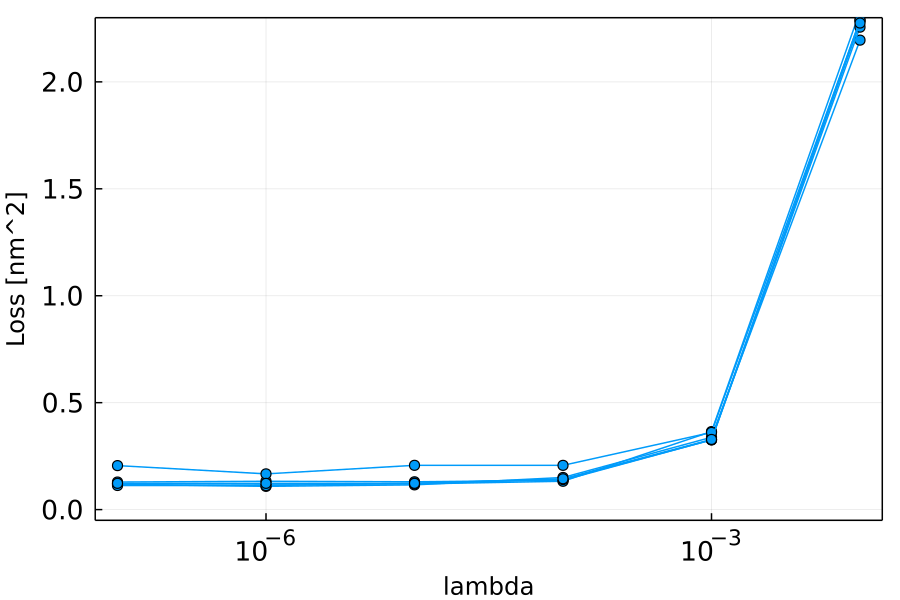

In [77]:
plot(lambdas, loss_over_lambdas_array[1] / 100.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
for i = 2:length(lambdas)
    plot!(lambdas, loss_over_lambdas_array[i] / 100.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1)
end

ylims!(-0.05, 2.3)
xlabel!("lambda", fontsize=35)
p = ylabel!("Loss [nm^2]", fontsize=35)

In [10]:
savefig(p, "blindtip_opening_randn01.png")

In [99]:
gr()

Plots.GRBackend()

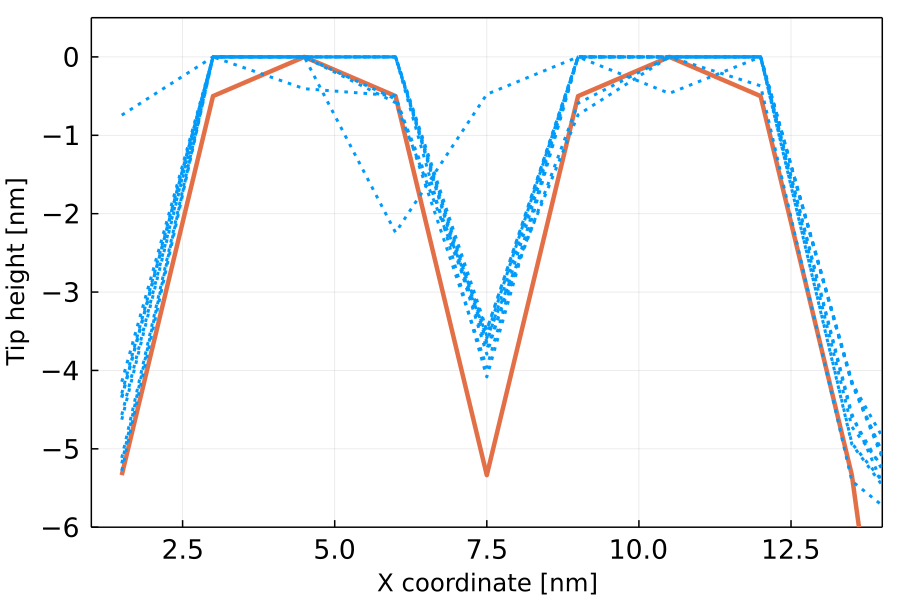

In [101]:
plot((collect(1:11)) .* resolution / 10.0, tip[4, 1:end] / 10.0, linewidth=3, label="ground truth", legend=:bottomright, color=2, 
      xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
for irealization = 1:nrealization
    if irealization == nrealization
        plot!(collect(1:11) .* resolution / 10.0, P_over_lambdas_array[irealization][5][4, :] / 10.0, linewidth=2, linestyle=:dot, color=1, label="reconstruction", framestyle=:box, dpi=150, fmt=:png)
    else
        plot!(collect(1:11) .* resolution / 10.0, P_over_lambdas_array[irealization][5][4, :] / 10.0, linewidth=2, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    end
end
ylims!((-6, 0.5))
xlims!((1, 14))
xlabel!("X coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

In [12]:
savefig(p, "blindtip_opening_randn02.png")

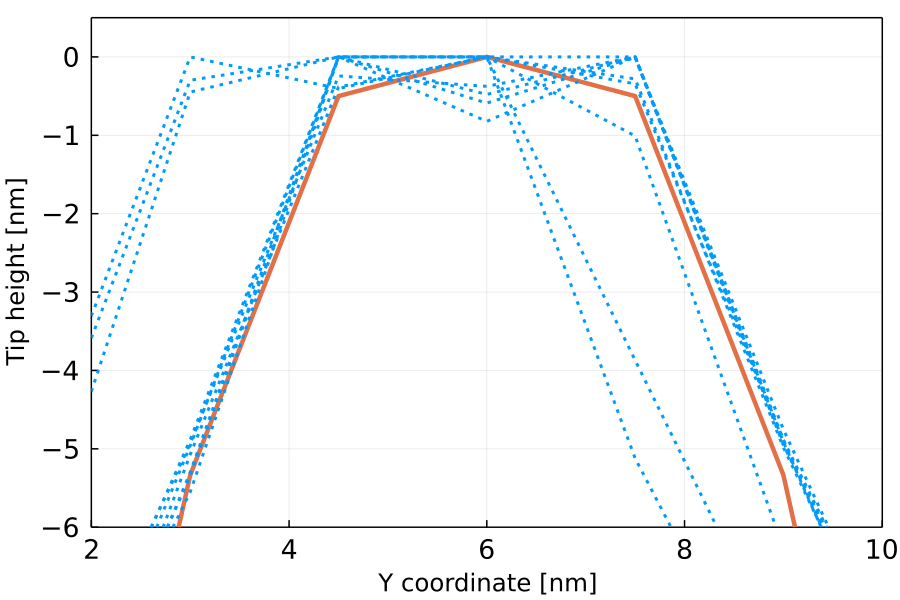

In [13]:
plot(collect(1:9) .* resolution / 10.0, tip[:, 3] / 10.0, linewidth=3, label="ground truth", color=2, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
for irealization = 1:nrealization
    if irealization == nrealization
        plot!(collect(1:9) .* resolution / 10.0, P_over_lambdas_array[irealization][1][:, 3] / 10.0, linewidth=2, linestyle=:dot, color=1, label="reconstruction", framestyle=:box, dpi=150, fmt=:png)
    else
        plot!(collect(1:9) .* resolution / 10.0, P_over_lambdas_array[irealization][1][:, 3] / 10.0, linewidth=2, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    end
end
ylims!((-6, 0.5))
xlims!((2, 10))
xlabel!("Y coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

#plot!(collect(1:9) .* resolution / 10.0, translate_tip_mean(P_over_lambdas_array[4][4])[:, 4] / 10.0, linewidth=5, linestyle=:solid, color=3, label=nothing, framestyle=:box, dpi=150, fmt=:png)

In [14]:
savefig(p, "blindtip_opening_randn03.png")

In [15]:
pyplot()

Plots.PyPlotBackend()

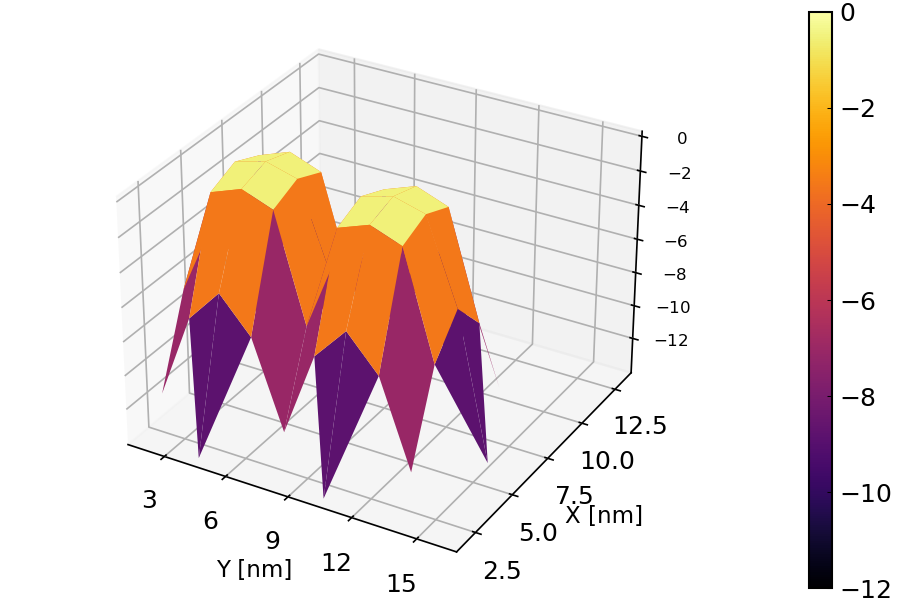

In [16]:
tip_tmp = deepcopy(tip)
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:11) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clims=(-12, 0),
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [17]:
savefig(p, "blindtip_opening_randn04.png")

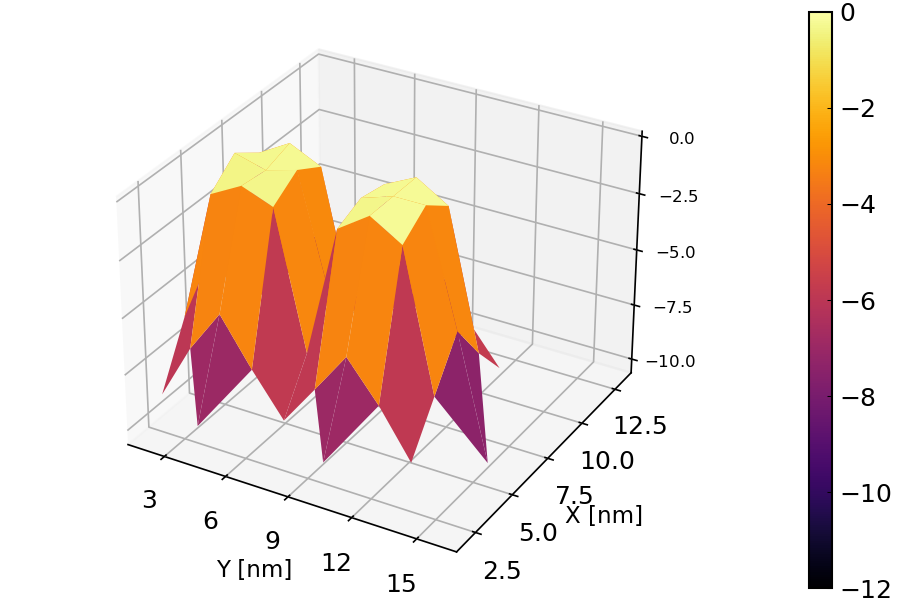

In [18]:
tip_tmp = deepcopy(P_over_lambdas_array[1][1])
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:11) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clims=(-12, 0), 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [19]:
savefig(p, "blindtip_opening_randn05.png")

In [20]:
gr()

Plots.GRBackend()

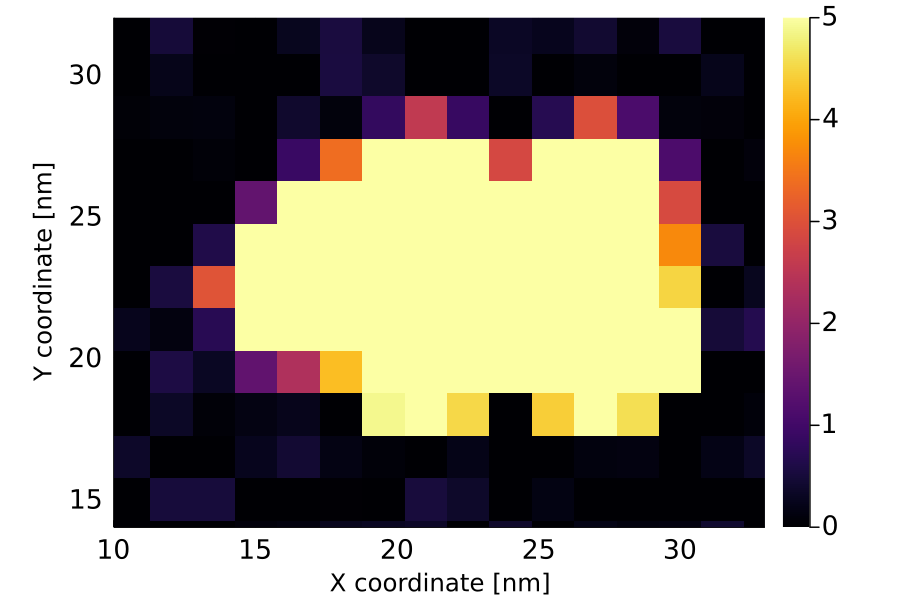

In [21]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images_randn[1] / 10.0, clim=(0, 5), dpi=150, fmt=:png, 
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [22]:
savefig(p, "blindtip_opening_randn06.png")

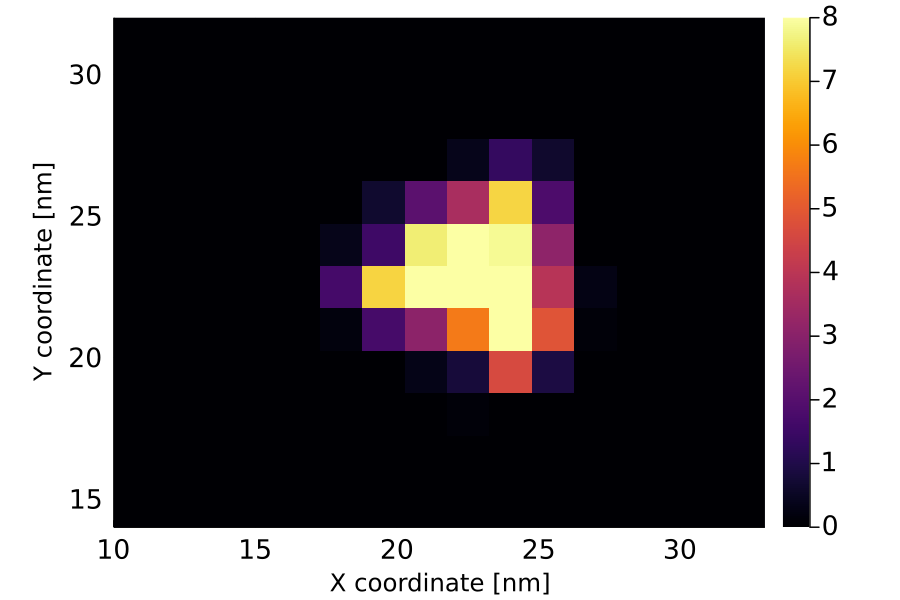

In [102]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images_randn[1], translate_tip_mean(P_over_lambdas_array[end][1])) / 10.0, clim=(0, 8), dpi=150, fmt=:png, 
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [24]:
savefig(p, "blindtip_opening_randn07.png")

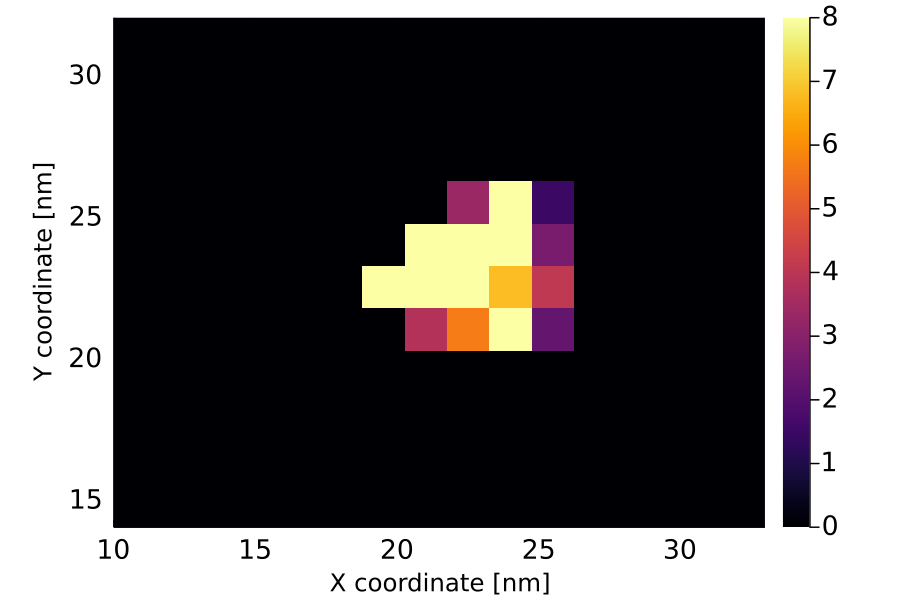

In [25]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, surfs[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png,
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [26]:
savefig(p, "blindtip_opening_randn08.png")

# Correlation

In [118]:
crosscor(image1, image2) = mean((image1 .- mean(image1)) .* (image2 .- mean(image2))) / (std(image1) * std(image2))
#pixel_rmsd(image1, image2) = sqrt(mean((image1 .- image2).^2))

function pixel_rmsd(image1, image2; cutoff = -80.0)
    image1_shifted = similar(image1)

    rmsd_min = Inf64
    for du = -2:2, dv = -2:2
        image1_shifted = circshift(image1, (du, dv))
        id = (image1_shifted .> cutoff) .| (image2 .> cutoff)
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

diff_tip = zeros(Float64, length(lambdas)*length(P_over_lambdas_array[:][1]), 2)
count = 0
for it = 1:length(lambdas)
    for ireal = 1:length(P_over_lambdas_array[:][it])
        c = pixel_rmsd(tip, P_over_lambdas_array[ireal][it])
        count += 1
        diff_tip[count, 1] = lambdas[it]
        diff_tip[count, 2] = c
    end
end

In [119]:
gr()

Plots.GRBackend()

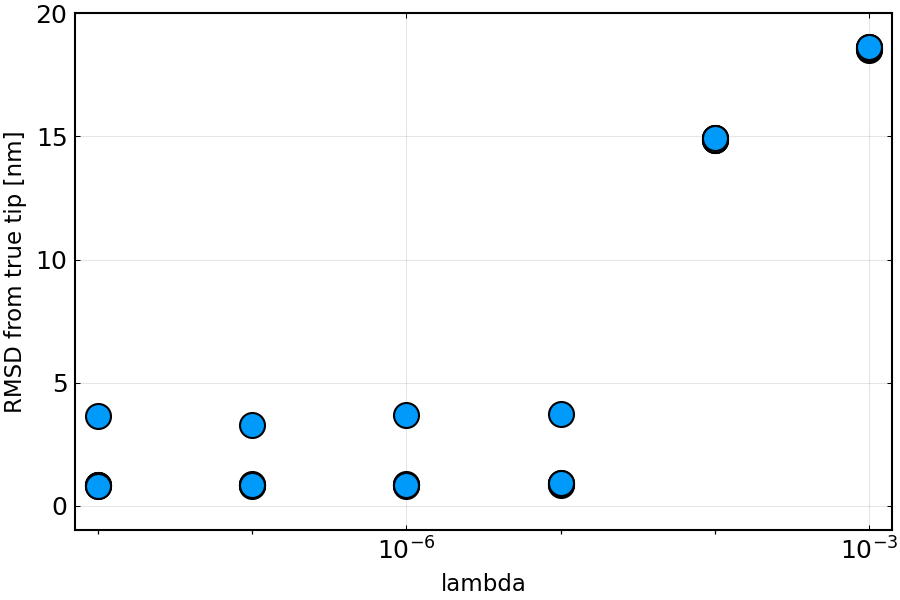

In [126]:
scatter(diff_tip[:, 1] / 10.0, diff_tip[:, 2] / 10.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
        xtickfontsize=12, ytickfontsize=12, legendfontsize=10, colorbar_tickfontsize=10, markersize=12, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("lambda", fontsize=35)
p = ylabel!("RMSD from true tip [nm]", fontsize=35)
ylims!(-1, 20)

In [122]:
diff_surf = zeros(Float64, length(lambdas)*length(P_over_lambdas_array[:][1])*length(images), 2)
count = 0
Random.seed!(777);
images_randn = deepcopy(images)

function pixel_rmsd(image1, image2; cutoff = 0.0)
    #id = (image1 .> cutoff) .| (image2 .> cutoff)

    rmsd_min = Inf64
    for du = -2:2, dv = -2:2
        image1_shifted = circshift(image1, (du, dv))
        id = (image1 .> cutoff) .| (image2 .> cutoff)
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

for it = 1:length(lambdas)
    for ireal = 1:length(P_over_lambdas_array[:][it])
        for iframe = 1:length(images)
            images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
            c = pixel_rmsd(surfs[iframe], ierosion(images_randn[iframe], P_over_lambdas_array[ireal][it]))
            count += 1
            diff_surf[count, 1] = lambdas[it]
            diff_surf[count, 2] = c
        end
    end
end

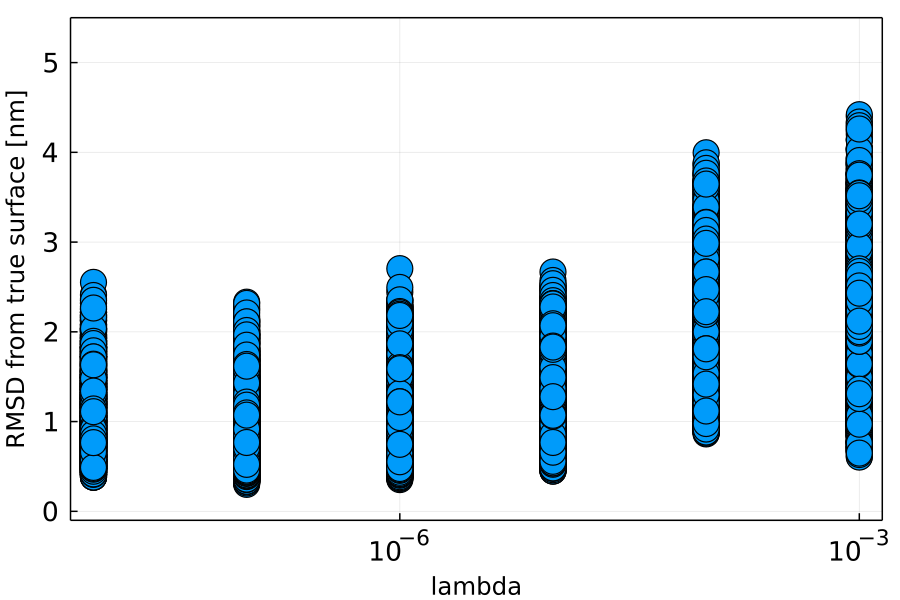

In [123]:
gr()
scatter(diff_surf[:, 1] / 10.0, diff_surf[:, 2] / 10.0, xaxis=:log, framestyle=:box, xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1,
        xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12, markersize=10, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("lambda", fontsize=35)
p = ylabel!("RMSD from true surface [nm]", fontsize=35)
ylims!(-0.1, 5.5)

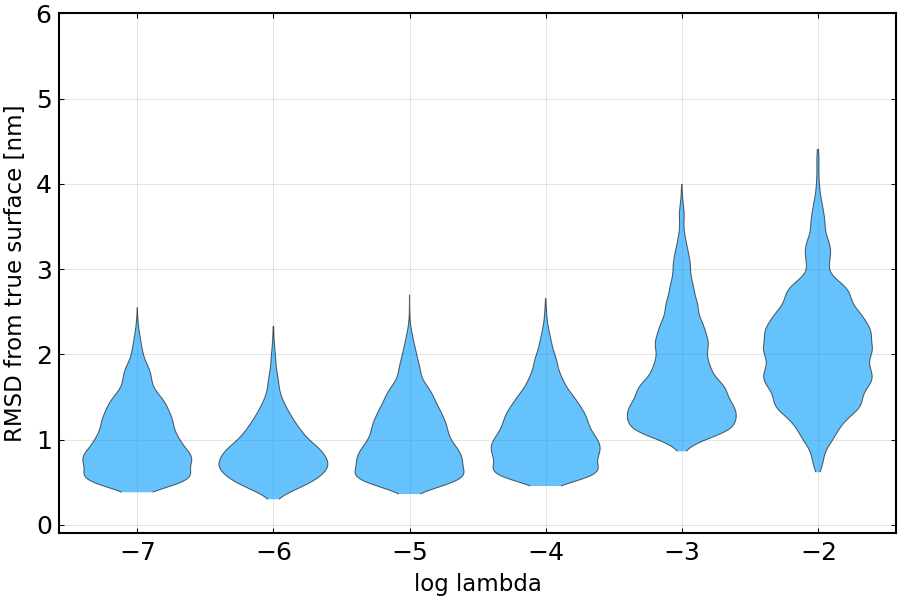

In [124]:
using StatsPlots
pyplot()

violin(log10.(diff_surf[:, 1]), diff_surf[:, 2] / 10.0, ylim=(-0.1, 6.0),
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       xlabel="log lambda", ylabel="RMSD from true surface [nm]", 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=1)

#ylims!(-0.1, 4.5)

# Save results

In [125]:
using BSON: @save, @load

@save "blindtip_opening_randn.bson" tip lambdas P_over_lambdas_array
@save "blindtip_opening_randn_rmsd.bson" diff_tip diff_surf